## NAAN: Neurologically Assessed Administration of Nicotine


This is a project by MACtion Potential, the NeurotechX associated club at McMaster University. Our goal with this project was to design a system that could give a dose of nicotine without conscious action of the user to prevent the formation of new habits. This would act as an alternative to nicotine addiction therapy protocols such as nicotine patches, gum, or e-cigarettes where the user must swap their smoking habit with an albeit less dangerous or weaker form of administration. The project is further described in the video also posted on our github page. This file is meant to offer an explanation of the code we have developed and explain some of the choices we made in regards to signal processing.


We would like to issue a special thank you to Alex Pleava, a former member who's very well documented code was used throughout this project.


This code relies on specific versions of multiple Python libraries. To use this code please run it in a Python environment containing the library versions found in the `requirements.txt` file. Additionally, this code uses some external functions from the included `muselsl_utils` file, so please ensure it is stored with this notebook.

In [2]:
import mne
import numpy
import matplotlib.pyplot as plt
import numpy
import pandas
import pylsl
from pylsl import StreamInlet, resolve_byprop
import scipy.stats
import statistics
import time
import sys
import os
import muselsl_utils

The following block of code contains two functions: `dominant_freq` and `baseline`.


`baseline` takes a recording from our Muse 2 device as a CSV and transforms it into a MNE raw array object. The array is then broken into four second windows which are each fed into `dominant_freq` which calculates the power spectral density using the multitaper method. The PSD is averaged across 4 channels to see which frequency in both the alpha and theta range has the most power, these are the dominant frequencies. `baseline` collects these frequencies as a distribution, representing the number of occurrences of each dominant frequency across the entire original baseline recording. These distributions can be visualised by running the following code block.


The most obvious question is how we chose the length of the windows that the baseline data and subsequent live data is sectioned into. After recording some data we found that excessively large windows didn't really generate a distribution at all, as each window tended to have the same dominant frequency. Due to the kind of analysis we planned on doing (distribution comparison through Mann-Whitney U test) we knew we needed at least some variation in the recorded distributions. However, we also wanted the longest possible window to ensure that some of the noise in the recording could hopefully average out and leave us with more meaningful measurements. We found that 8 second windows generated a relatively smooth and continuous distribution which we interpreted as successful.


Unfortunately, the distributions we found were far from Guassian. We found that the slowest frequencies appeared more frequently (4 Hz and 8 Hz), and that the likelihood of a window containing data was inversely proportional to the frequency. This non-normality was dealt with by using a non-parametric test. The Mann-Whitney U test was additionally ideal because the number of samples in each distribution need not be equal. This would allow a longer baseline to be taken without needing to store a larger live distribution onboard the device. 


In [3]:
def dominant_freq(window):

    #performs a power spectral display function on both the alpha and theta range
    psd_raw_alpha=numpy.array(mne.time_frequency.psd_multitaper(window,fmin=8,fmax=13,picks=["AF7","AF8","TP9","TP10"]))
    psd_raw_theta=numpy.array(mne.time_frequency.psd_multitaper(window,fmin=4,fmax=8,picks=["AF7","AF8","TP9","TP10"]))

#calculates dominant frequency by collapsing power spectral density across all 4 channels and taking the frequency with the largest sum
####################################################################
    store = numpy.sum(psd_raw_alpha[0], axis=0)
    max_index=numpy.argmax(store)
    dominant_alpha= psd_raw_alpha[1]
    dominant_alpha= dominant_alpha[max_index]

#performs the same as above on the theta range
####################################################################
    store = numpy.sum(psd_raw_theta[0], axis=0)
    max_index=numpy.argmax(store)
    dominant_theta= psd_raw_theta[1]
    dominant_theta= dominant_theta[max_index]


    return [dominant_alpha, dominant_theta]


#user will be the patient that we are working with, this will generate a distribution of dominant frequencies
#then we can work with the descriptive statistical measures from this distribution
def baseline(user):

    #defines some parameters to be used by the MNE library, specific to our recording setup
    info = mne.create_info(["timestamps","TP9","AF7","AF8", "TP10", "Right AUX"], 256, ch_types="eeg")

    #imports the raw recording data from the Data folder, 
    raw_recording = pandas.read_csv(str("Data/"+user+"_Baseline.csv"))
    print("Data imported...")
    #takes the raw recording and moves it into an MNE raw array object, allows for easier manipulation later
    #this is a different transformation than later as we are working with a Pandas object
    old_stdout = sys.stdout # backup current stdout
    sys.stdout = open(os.devnull, "w")
    raw_array = mne.io.RawArray(raw_recording.values.T/1000000, info)
    sys.stdout = old_stdout
    print("Raw csv moved to raw_array...")
    #note that we are working with a setup recording at 256 Hz, thus a 256 time step sample represents one second
    step=0 #sets the start point of our window
    max=len(raw_array) #sets the max sample point of our recording
    distribution=[]
    alpha_dist = []
    theta_dist = []
    print("Windowing data...")
    while step<max:
        old_stdout = sys.stdout # backup current stdout
        sys.stdout = open(os.devnull, "w")
        #takes an eight second sample from the raw recording
        raw_window=raw_array.get_data(picks=None, start=step,stop=(step+2048))
        #again moves this array into ane MNE raw array object            
        mne_window = mne.io.RawArray(raw_window, info)
        #advances the sample window forward by a second
        step=step+2048
        try:
            doms = dominant_freq(mne_window)
            alpha_dist.append(round(doms[0],3))
            theta_dist.append(round(doms[1],3))
        
        except ValueError:
            print("distributions generated...")
        sys.stdout = old_stdout

    print("Distributions created!")
    return (alpha_dist, theta_dist)
        
        
alpha_dist, theta_dist = baseline("Submit")

Data imported...
Raw csv moved to raw_array...
Windowing data...


C:\Users\Jacob\AppData\Local\Temp\ipykernel_11312\3818942588.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  psd_raw_alpha=numpy.array(mne.time_frequency.psd_multitaper(window,fmin=8,fmax=13,picks=["AF7","AF8","TP9","TP10"]))
C:\Users\Jacob\AppData\Local\Temp\ipykernel_11312\3818942588.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  psd_raw_theta=numpy.array(mne.time_frequency.psd_multitaper(window,fmin=4,fmax=8,picks=["AF7","AF8","TP9","TP10"]))


Distributions created!


Text(0.5, 0, 'Dominant Frequency')

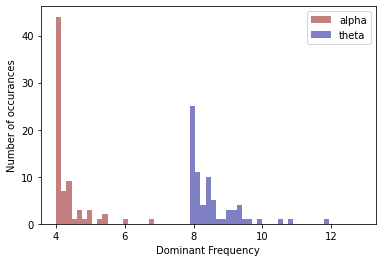

In [4]:
bin_list = numpy.arange(4,13,.15)

fig = plt.figure()
plt.hist(theta_dist,bin_list, alpha=0.5,color="darkred",label="alpha")
plt.hist(alpha_dist,bin_list, alpha=0.5,color="darkblue",label="theta")
plt.legend()

plt.ylabel('Number of occurances')
plt.xlabel('Dominant Frequency')

The following block contains the code involved with the assessment of live data. Upon initialization of a connection to the Muse, 8 second windows of the incoming data are taken and the dominant frequencies found using the above mentioned `baseline` functions.


75 windows are analysed (corresponding to the 10 minute baseline recording) before comparisons begin. After the first comparison, the next incoming dominant frequency is added to the distribution as the oldest one is removed. Thus the distribution represents the most recent 10 minutes of activity.


If at any point both the alpha and theta dominant frequency distributions are significantly lower than the baseline the patient is said to be in withdrawal and a signal can be sent to the designed mechanical device to administer nicotine. "Significance" in this case was chosen as a p-value of 0.05 as is normal, but again this can be altered after more experimental data is taken.


*Note that this code requires a connection to a Muse device to run. We used a Muse 2016 headband connected using BlueMuse and thus cannot guarantee that this code will run using different software or hardware.*


In [5]:
def live_run():

    ### THESE ARE EXPERIMENTAL PARAMETERS ###   

    # Length of the EEG data buffer (in seconds)
    # This buffer will hold last n seconds of data and be used for calculations
    BUFFER_LENGTH = 16

    # This is the batch size that out code will grab from the buffer when it is ready to process the new data
    EPOCH_LENGTH = 8

    # Amount of overlap between two consecutive epochs (in seconds)
    OVERLAP_LENGTH = 0

    # Amount to 'shift' the start of each next consecutive epoch
    SHIFT_LENGTH = EPOCH_LENGTH - OVERLAP_LENGTH


    if __name__ == "__main__":

        """ 1. CONNECT TO EEG STREAM """

        # Search for active LSL streams
        print('Looking for an EEG stream...')
        streams = pylsl.resolve_byprop('type', 'EEG', timeout=2)
        if len(streams) == 0:
            raise RuntimeError('Can\'t find EEG stream.')

        # Set active EEG stream to inlet and apply time correction
        print("Start acquiring data")
        inlet = StreamInlet(streams[0], max_chunklen=12)
        eeg_time_correction = inlet.time_correction()

        # Get the stream info and description
        info = inlet.info()
        description = info.desc()

        # Get the sampling frequency
        # This is an important value that represents how many EEG data points are
        # collected in a second. This influences our frequency band calculation.
        # for the Muse 2016, this should always be 256
        fs = int(info.nominal_srate())

        """ 2. INITIALIZE BUFFERS """

        # Initialize raw EEG data buffer - 256*5 x 4 array to store the last 5 seconds
        eeg_buffer = numpy.zeros((int(fs * BUFFER_LENGTH), 4))
        filter_state = None  # for use with the notch filter

        # Compute the number of epochs in "buffer_length"
        n_win_test = int(numpy.floor((BUFFER_LENGTH - EPOCH_LENGTH) /
                                SHIFT_LENGTH + 1))

        # Initialize the band power buffer (for plotting)
        # bands will be ordered: [delta, theta, alpha, beta]
        band_buffer = numpy.zeros((n_win_test, 4))

        """ 3. GET DATA """
        info = mne.create_info(["TP9","AF7","AF8", "TP10"], 256, ch_types="eeg")
        # The try/except structure allows to quit the while loop by aborting the
        # script with <Ctrl-C>
        print('Press Ctrl-C in the console to break the while loop.')

        a_store=[]
        t_store=[]
        try:
            counter=0
            # The following loop acquires data, computes band powers, and calculates neurofeedback metrics based on those band powers
            while True:

                time.sleep(8)


                """ 3.1 ACQUIRE DATA """
                # Obtain EEG data from the LSL stream
                eeg_data, timestamp = inlet.pull_chunk(
                    timeout=1, max_samples=int(SHIFT_LENGTH * fs))


                # Only keep the channel we're interested in
                ch_data = numpy.array(eeg_data)[:, 0:4]

                # Update EEG buffer with the new data
                #this eeg_buffer is a 5 second store of data, sampled at 256 Hz, it is a numpy array
                eeg_buffer, filter_state = muselsl_utils.update_buffer(
                    eeg_buffer, ch_data, notch=False,
                    filter_state=filter_state)
            
                if eeg_buffer[0,0] != 0:

                    """ 3.2 COMPUTE BAND POWERS """
                    # Get newest samples from the buffer
                    data_epoch = muselsl_utils.get_last_data(eeg_buffer,
                                                EPOCH_LENGTH * fs)

                    #had to transpose to process with MNE package
                    data_epoch = numpy.transpose(data_epoch)

                    #transforms the pulled epoch from an np array to an MNE epoch object
                    mne_epoch = mne.io.RawArray(data_epoch, info)

                    #calls upon previously defined function to pull dominant frequencies for the chunk
                    freqs = dominant_freq(mne_epoch)
                    
                    #if the store is 75 samples long 
                    if len(a_store) == 75:
                        #remove first sample
                        a_store.pop(0) 
                        #add most recent generated sample to end of store
                        a_store.append(round(freqs[0],3))
                    else:
                        #add most recent generated sample to end of store
                        a_store.append(round(freqs[0],3))
            
                    #same for theta range
                    if len(t_store) == 75:
                        t_store.pop(0) 
                        t_store.append(round(freqs[0],3))
                    else:
                        t_store.append(round(freqs[1],3))
                
                    print(a_store)

                #if we have sufficient samples, perform a kruskal wallace test on each set of dominant frequencies
                if len(a_store)==75:
                    ap = scipy.stats.mannwhitneyu(x=a_store,y=alpha_dist, use_continuity=True, alternative='less', axis=0, method='auto')
                    tp = scipy.stats.mannwhitneyu(x=t_store,y=theta_dist, use_continuity=True, alternative='less', axis=0, method='auto')
                    if ap[1] < 0.05:
                        if tp[1] < 0.05:
                            print("The patient is experiencing nicotine withdrawal.")
                            state = 1
                    else:
                        print("The patient is not experiencing nicotwithdrawal.")
                        state = 0 
        except KeyboardInterrupt:
            print('Closing!')
            return None

live_run()

Looking for an EEG stream...


RuntimeError: Can't find EEG stream.